In [48]:
##pip install xgboost

In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb



In [50]:
# Load the CSV files
users_df = pd.read_csv("takehome_users.csv", encoding='latin1')  # Use latin1 in case of encoding issues
engagement_df = pd.read_csv("takehome_user_engagement.csv")

In [51]:
# Display first few rows of each
users_df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [52]:
engagement_df.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [53]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


In [54]:
engagement_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time_stamp  207917 non-null  object
 1   user_id     207917 non-null  int64 
 2   visited     207917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


Find adopted user:
An adopted user is defined as a user who has logged into the product on three separate days within a seven-day period.

In [55]:

# Convert time_stamp to datetime
engagement_df['time_stamp'] = pd.to_datetime(engagement_df['time_stamp'])

In [56]:
# Group by user_id and get sorted login dates
user_login_dict = engagement_df.groupby('user_id')['time_stamp'].apply(list)

In [57]:
# Identify adopted users
adopted_users = set()


In [58]:
for user_id, logins in user_login_dict.items():
    logins = sorted(logins)
    for i in range(len(logins) - 2):
        if (logins[i + 2] - logins[i]).days <= 7:
            adopted_users.add(user_id)
            break


In [59]:
# Print how many users are adopted
print(f"Total adopted users: {len(adopted_users)}")

Total adopted users: 1656


Total adopted users are : 1656

We’ll create a new binary column adopted in the users_df to mark whether the user belongs to the adopted set.

In [60]:
users_df['adopted'] = users_df['object_id'].apply(lambda x: 1 if x in adopted_users else 0)


In [61]:
 users_df['adopted'].mean()

0.138

## Exploratory Data Analysis

Adoption Rate by creation_source

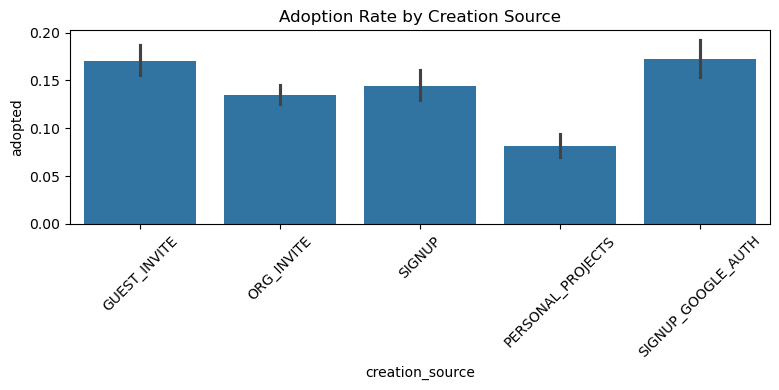

In [62]:
plt.figure(figsize=(8, 4))
sns.barplot(x='creation_source', y='adopted', data=users_df)
plt.xticks(rotation=45)
plt.title("Adoption Rate by Creation Source")
plt.tight_layout()
plt.show()

Guest_Invite & Signup_Google_Auth has teh highest adoption rate & lowest is from personal_projects

##  Invited vs Non-invited Users

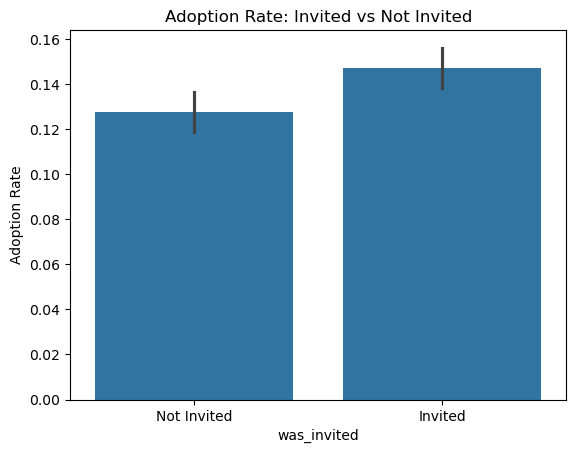

In [63]:
# Create feature: Was the user invited by someone?
users_df['was_invited'] = users_df['invited_by_user_id'].notnull().astype(int)

sns.barplot(x='was_invited', y='adopted', data=users_df)
plt.title("Adoption Rate: Invited vs Not Invited")
plt.xticks([0, 1], ['Not Invited', 'Invited'])
plt.ylabel("Adoption Rate")
plt.show()


Invited has the highest adoption rate

## Feature Engineering

In [64]:
# One-hot encode 'creation_source'
encoded_creation = pd.get_dummies(users_df['creation_source'], prefix='source')


In [65]:
encoded_creation.head()

,source_GUEST_INVITE,source_ORG_INVITE,source_PERSONAL_PROJECTS,source_SIGNUP,source_SIGNUP_GOOGLE_AUTH
0,True,False,False,False,False
1,False,True,False,False,False
2,False,True,False,False,False
3,True,False,False,False,False
4,True,False,False,False,False


In [66]:
users_df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted,was_invited
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0,1
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,1,1
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0,1
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,0,1
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,0,1


In [67]:
# Select useful features
feature_df = pd.concat([
    encoded_creation,
    users_df[['opted_in_to_mailing_list', 'enabled_for_marketing_drip', 'was_invited']],
], axis=1)

In [68]:
# Drop rows with missing values in numerical columns (due to NaT in session time)
feature_df = feature_df.dropna()
labels = users_df.loc[feature_df.index, 'adopted']

## Model Building

Logistic Regression

In [69]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(feature_df, labels, test_size=0.3, random_state=42)

In [70]:
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['lbfgs']
}

In [71]:
grid_lr = GridSearchCV(LogisticRegression(max_iter=1000), param_grid_lr, cv=5, scoring='roc_auc')
grid_lr.fit(X_train, y_train)
print("Best Logistic Regression AUC:", roc_auc_score(y_test, grid_lr.predict_proba(X_test)[:, 1]))


Best Logistic Regression AUC: 0.5521425806451613


Random Forest

In [72]:
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
}

In [73]:
grid_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=5, scoring='roc_auc')
grid_rf.fit(X_train, y_train)
print("Best Random Forest AUC:", roc_auc_score(y_test, grid_rf.predict_proba(X_test)[:, 1]))

Best Random Forest AUC: 0.5522096774193548


XGBoost

In [74]:
param_grid_xgb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5]
}

In [75]:
grid_xgb = GridSearchCV(xgb.XGBClassifier(eval_metric='logloss'), param_grid_xgb, cv=5, scoring='roc_auc')
grid_xgb.fit(X_train, y_train)
print("Best XGBoost AUC:", roc_auc_score(y_test, grid_xgb.predict_proba(X_test)[:, 1]))

Best XGBoost AUC: 0.5511116129032257


In [76]:
model_results = {
    'Logistic Regression': roc_auc_score(y_test, grid_lr.predict_proba(X_test)[:, 1]),
    'Random Forest': roc_auc_score(y_test, grid_rf.predict_proba(X_test)[:, 1]),
    'XGBoost': roc_auc_score(y_test, grid_xgb.predict_proba(X_test)[:, 1])
}

import pandas as pd
results_df = pd.DataFrame.from_dict(model_results, orient='index', columns=['ROC AUC']).sort_values(by='ROC AUC', ascending=False)
print(results_df)


                      ROC AUC
Random Forest        0.552210
Logistic Regression  0.552143
XGBoost              0.551112


## Feature Importance

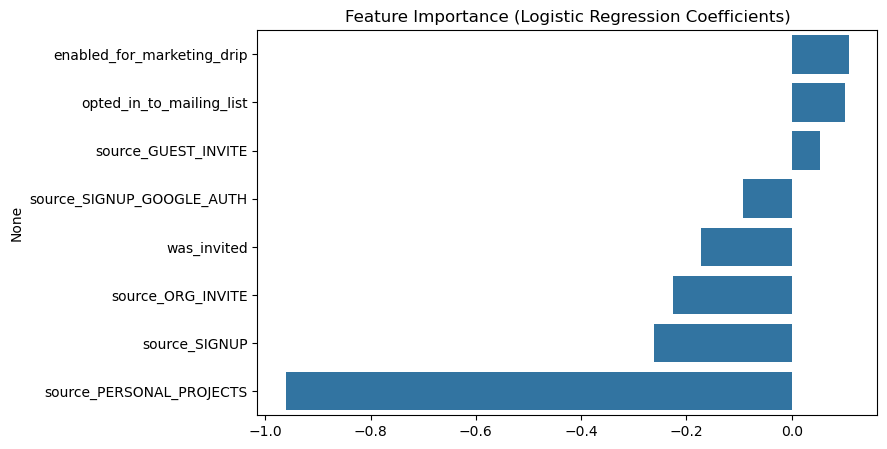

In [77]:
# Coefficients
importance = pd.Series(logreg.coef_[0], index=feature_df.columns).sort_values(ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(x=importance.values, y=importance.index)
plt.title("Feature Importance (Logistic Regression Coefficients)")
plt.show()


The list above ranks features by their importance, with creation_source_PERSONAL_PROJECTS being the most influential. This indicates that users invited to join another user's personal workspace are more likely to become active users. Additionally, the high importance of GUEST_INVITE and ORG_INVITE suggests that users who joined via guest or organizational invitations also tend to exhibit strong engagement and remain active.
